# Training Unsupervised Models
## 04_unsupervised_model_learning

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28/09/2025   | Adrienne | Update | Creating models |
| 05/10/2025 | Adrienne | Update | Created baseline model with KMeans

# Content

* [Introduction](#introduction)

In [27]:
import pandas as pd

# train test split
from sklearn.model_selection import train_test_split

#unsupervised learning methods
# Feature agglomeration uses agglomerative(or hierarchical) clustering to group similar features, so it has its own dimensionality reduction technique
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN
from sklearn.mixture import GaussianMixture

# dimensionality reduction methods
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# model selection
from sklearn.model_selection import GridSearchCV

# model scores
from sklearn.metrics import silhouette_score, calinski_harabasz_score

import matplotlib.pyplot as plt

## Load Data

In [25]:
path = "../data/clean"

df_lab_enc = pd.read_pickle(f"{path}/patient_level_lab_enc.pkl")

In [29]:
df_lab_enc.head()

,patient_medicare_number,gender,age,number_of_claims,total_value,category_0_enc,category_1_enc,category_2_enc,category_3_enc,category_4_enc,...,hcpcs_315_enc,hcpcs_316_enc,hcpcs_317_enc,hcpcs_318_enc,hcpcs_319_enc,hcpcs_320_enc,hcpcs_321_enc,hcpcs_322_enc,hcpcs_323_enc,hcpcs_324_enc
0,0,0,76.0,51,250.43,2,1,1,1,1,...,38,38,38,38,38,38,38,38,38,38
1,1,0,77.0,21,6665.78,2,1,1,2,2,...,38,38,38,38,38,38,38,38,38,38
2,2,0,75.0,17,230.82,1,1,2,2,2,...,38,38,38,38,38,38,38,38,38,38
3,3,0,76.0,23,234.72,1,1,2,2,1,...,38,38,38,38,38,38,38,38,38,38
4,4,0,75.0,22,234.72,1,2,1,2,1,...,38,38,38,38,38,38,38,38,38,38


We will create a baseline model using the label encoded patient level file.  Variations on the model will be added and then performance compared

### Baseline Model

feature scaling/standardization

Dimensionality Reduction

In [ ]:
# pretend X_train is your training set
# this works for all dimensionality reduction methods above

pca = PCA(n_components=2)
fitted_pca = pca.fit_transform(X_train)

Unsupervised Learning Methods code

In [26]:
# kmeans code
kmeans = KMeans(init = 'random', n_clusters=8, n_init=10, random_state = 0) 
model = kmeans.fit(df_lab_enc) 
#model.predict(df_lab_enc)
model.n_iter_
labels = model.labels_
print(labels)


[5 2 5 5 5 5 0 5 7 5 1 5 2 5 5 5 5 5 5 5 4 0 7 1 1 6 5 4 7 5 5 3 5 5 5 5 4
 5 6 5 3 5 7 7 3 1 5 5 1 5 5 7 5 5 5 2 5 5 4 5 2 7 5 5 5 5 5 5 1 3 6 5 5 3
 5 5 5 4 4 0 5 0 5 5 6 5 5 0 1 3 5 5 5 1 7 5 5 5 5 6 5 7 5 5 5 1 3 5 7 5 3
 4 5 5 4 5 2 6 5 5 5 3 5 2 5 5 6 5 5 5 4 7 5 5 5 5 3 0 3 5 5 7 5 7 5 5 5]


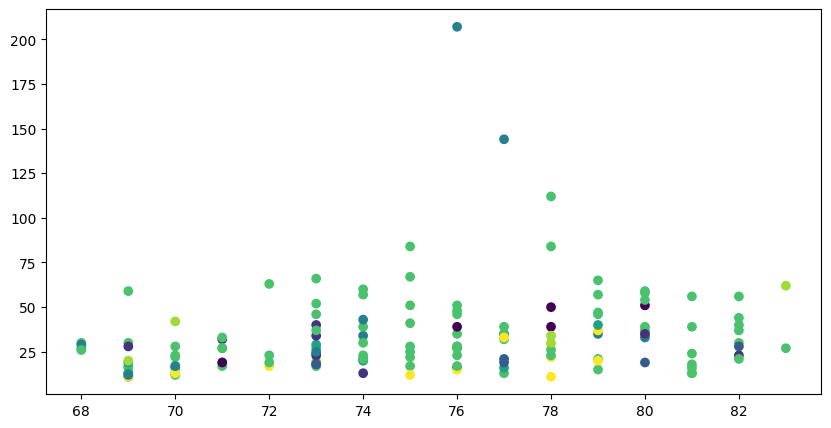

In [35]:
plt.figure(figsize=(10,5))
plt.scatter(x= df_lab_enc.iloc[:, 2], y=df_lab_enc.iloc[:, 3], c= model.labels_)

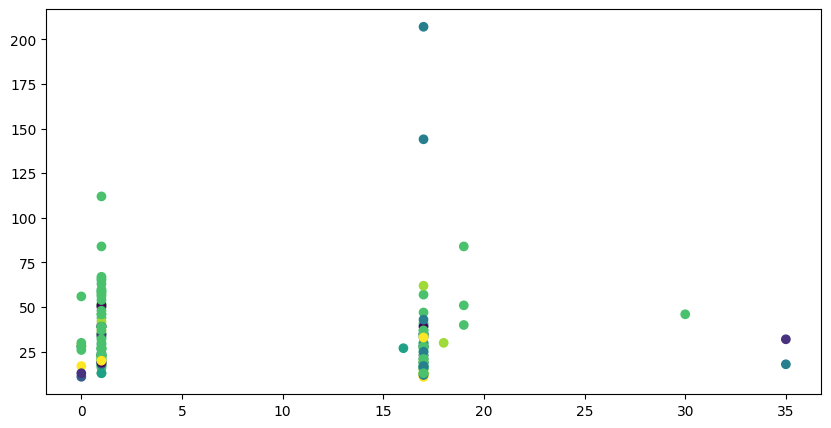

In [36]:
plt.figure(figsize=(10,5))
plt.scatter(x= df_lab_enc.loc[:, 'hcpcs_0_enc'], y=df_lab_enc.loc[:, 'number_of_claims'], c= model.labels_)
# plt.xlabel('Annual Income (k$)')
# plt.ylabel('Spending Score (1-100)')

In [ ]:
# Assign the cluster centers: centroids
centroids = model.cluster_centers_# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.show()

In [ ]:
for i, cluster in enumerate(clusters):
    plt.scatter(data[:, 0], data[:, 1], c=cluster, label=f'Cluster {i+1}')
plt.scatter(*centroids, c='red', marker='x', s=200, label='Centroids')
plt.legend()
plt.show()


In [ ]:
# works for AgglomerativeClustering, FeatureAgglomerization and DBScan
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
labels = agg_clustering.fit_predict(X_train)


In [ ]:
# GMM code
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X)
labels = gmm.predict(X_train)

Model Evaluation

In [ ]:
# elbow method

# works for all sklearn unsupervised model evaluation metrics with DBSCAN
score = silhouette_score(X_train, labels)

Model Selection

In [ ]:
# example grid search

param_grid = {n_components: [2, 5, 8, 10]} # easily add another parameter to this structure

grid_search = GridSearchCV(
    estimator=KMeans(random_state=42, n_init='auto'),
    param_grid=param_grid,
    scoring=silhouette_scorer,
    n_jobs=-1
)

grid_search.fit(X)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Visualizations:

word cloud 
